## 1. Problem definition:
- Titanic  is based on the sinking of the ‘Unsinkable’ ship Titanic in the early 1912. The dataset 'train' provides information about multiple passengers, including their ages, sexes, sibling counts, embarkment points and whether or not they survived the disaster. Based on these features, I have tried to predict if an arbitrary passenger on Titanic would survive the sinking

### Approach
- Explore the given data set 
- Feature engineer the variables to be fit for the model
- Train the model 
- cross validate, if needed change the parameters
- calculate the test score 
- (deploy model)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 1.1 Split data set in test and train

In [3]:
x = df_train[['PassengerId', 'Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = df_train['Survived']

In [4]:
#xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
#xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

In [5]:
#df_train = pd.concat([ytrain, xtrain], axis=1)
#df_train.head(), df_train.shape

In [6]:
#df_test = pd.concat([ytest, xtest], axis=1)
#df_test.head(), df_test.shape

## 2. Explore data set
- and see implications on survival rate

### Survival by Age
- Generally younger passengers seem to have been more likely to survive the sinking of the titanic

Text(0.5, 1.0, 'died')

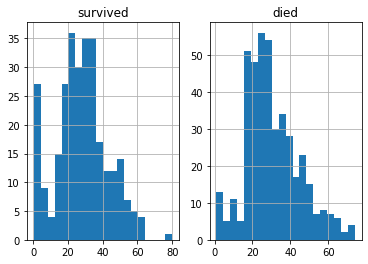

In [7]:
plt.subplot(1,2,1) # a rows and b columns and the cth plot from that
hist_sur = df_train[df_train.Survived == 1]['Age']
hist_sur.hist(bins=20)
plt.title('survived')
plt.subplot(1,2,2)
hist_not = df_train[df_train.Survived == 0]['Age']
hist_not.hist(bins=20)
plt.title('died')

### Survival by Gender
- men where far more likely to die on the titanic 

Text(0.5, 1.0, 'Survival by Gender')

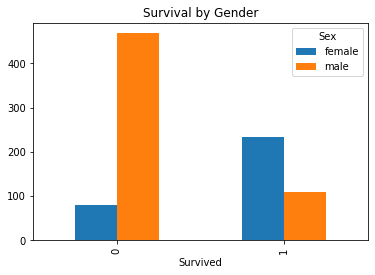

In [8]:
table = df_train[['Sex','Survived','PassengerId']].groupby(['Survived','Sex'])['PassengerId'].count().unstack()
table1 = table.plot.bar()
plt.title('Survival by Gender')

### Survival by Pclass
- First class passengers were more likely to survive, while 3rd class passengers where more likely to die

Text(0.5, 1.0, 'Survival by Pclass')

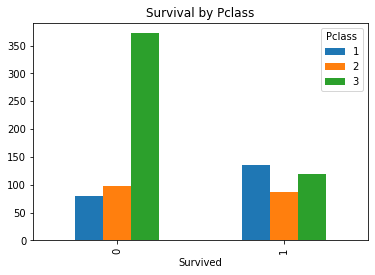

In [9]:
table2 = df_train[['Pclass','Survived','PassengerId']].groupby(['Survived','Pclass'])['PassengerId'].count().unstack()
table3 = table2.plot.bar()
plt.title('Survival by Pclass')

### Survival by Fare

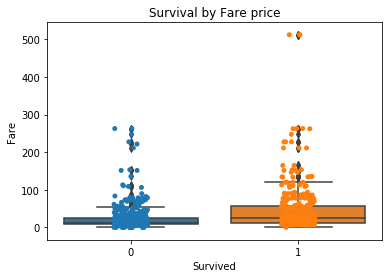

In [10]:
ax2 = sns.boxplot(x="Survived", y="Fare", 
                data=df_train)
ax2 = sns.stripplot(x="Survived", y="Fare",
                   data=df_train, jitter=True,
                   edgecolor="gray")
plt.title("Survival by Fare price",fontsize=12);

Text(0.5, 1.0, 'Survival by port of embarkation')

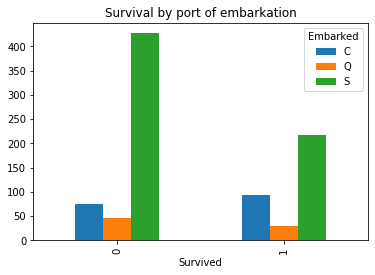

In [11]:
table4 = df_train[['Embarked','Survived','PassengerId']].groupby(['Survived','Embarked'])['PassengerId'].count().unstack()
table5 = table4.plot.bar()
plt.title('Survival by port of embarkation')

32.2042079685746


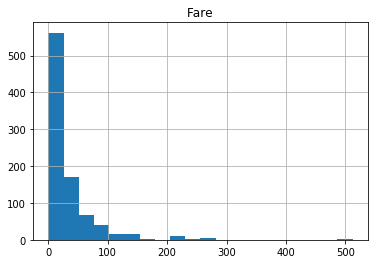

In [12]:
hist_fare = df_train['Fare']
hist_fare.hist(bins=20)
plt.title('Fare')
print(df_train.Fare.mean())

### Multi feature visualisation 
- Gender split in plots for male and female
- Shows survival by Pclass and age of passenger

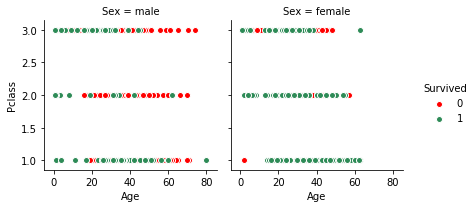

In [13]:
grid = sns.FacetGrid(df_train, hue="Survived", col="Sex", margin_titles=True,
                  palette={1:"seagreen", 0:"red"})
grid = grid.map(plt.scatter, "Age", "Pclass",edgecolor="w").add_legend();

### Feature correlation to decide on usage in the model
- Looking at the row/column 'Survived', highest correclation with 'Pclass', 'Fare', 'Parch' and 'age'
- thus these will be used to train the model
- Sex is not yet a numerical value, so cannot be checked

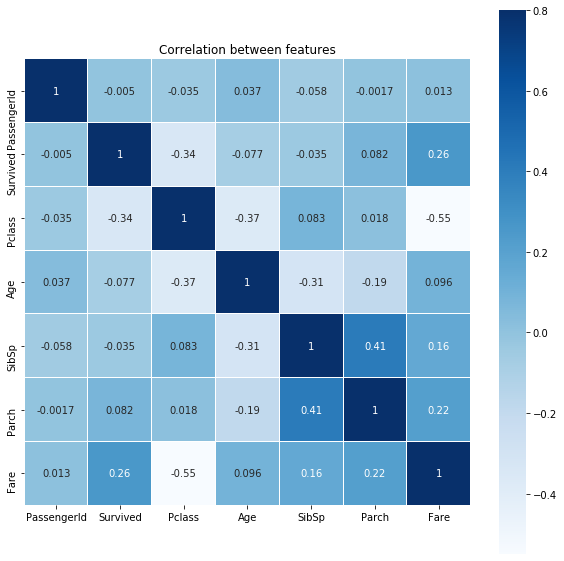

In [14]:
corr=df_train.corr() #["Survived"]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='Blues',linecolor="white")
plt.title('Correlation between features');

In [15]:
df_train.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

## 3. Feature engineering of the dataset

### Check for missing values in the data set
- missing values age
- missing values in Cabin
- missing values in Embarked

In [16]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Text(0.5, 1, 'Missing values heatmap')

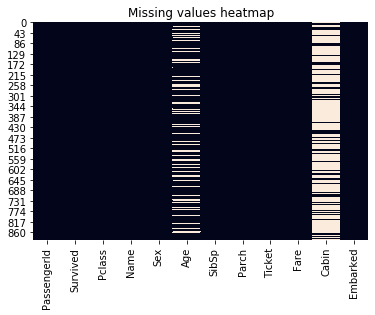

In [18]:
df_train.isnull().sum()
sns.heatmap(df_train.isnull(), cbar = False).set_title("Missing values heatmap")

In [19]:
df_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Treating missing values in the data set
- Replace missing age values with mean of Pclass and Sex
- Replace missing Embarked port with Southhampton as most people embarked here and its only 2 missing rows

In [20]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby(['Pclass','Sex'])['Age'].transform('mean'))
df_train["Embarked"] = df_train["Embarked"].fillna('S')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
test['Age'] = test['Age'].fillna(test.groupby(['Pclass','Sex'])['Age'].transform('mean'))
test["Embarked"] = test["Embarked"].fillna('S')
test["Fare"] = test["Fare"].fillna(test.Fare.mean())
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Mapping string male and female to a binary value 0,1

In [22]:
mapping = {'male':0, 'female':1}
df_train = df_train.replace({'Sex':mapping})
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [23]:
test = test.replace({'Sex':mapping})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S


Use one hot encoding to convert columns 'Embarked', 'Sex','Pclass' and attach at the end of the data frame

In [24]:
onehot_train = pd.get_dummies(df_train['Embarked'], prefix='Embarked_')
df_train2 = pd.concat([df_train, onehot_train], axis=1)
df_train2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [25]:
onehot_test = pd.get_dummies(test['Embarked'], prefix='Embarked_')
test2 = pd.concat([test, onehot_test], axis=1)
test2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,0,1


Include 4 bins for column Age in the data set and append at the end

In [26]:
bins_train = pd.cut(df_train2['Age'], bins=4)
bins_train = pd.get_dummies(bins_train, prefix='Age')
df_train3 = pd.concat([df_train2, bins_train], axis=1)
df_train3 = df_train3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.34, 20.315]':'Age_0.3-20.3', 'Age_(20.315, 40.21]':'Age_20.3-40.2','Age_(40.21, 60.105]':'Age_40.2-60.1','Age_(60.105, 80.0]':'Age_60.1-80.0'})
df_train3.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S,Age_0.3-20.3,Age_20.3-40.2,Age_40.2-60.1,Age_60.1-80.0
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,1,0,0


In [27]:
bins_test = pd.cut(test2['Age'], bins=4)
bins_test = pd.get_dummies(bins_test, prefix='Age')
test3 = pd.concat([test2, bins_test], axis=1)
test3 = test3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.34, 20.315]':'Age_0.3-20.3', 'Age_(20.315, 40.21]':'Age_20.3-40.2','Age_(40.21, 60.105]':'Age_40.2-60.1','Age_(60.105, 80.0]':'Age_60.1-80.0'})
test3.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S,"Age_(0.0942, 19.128]","Age_(19.128, 38.085]","Age_(38.085, 57.043]","Age_(57.043, 76.0]"
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,0,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,0,1,0,0


### Rechecking feature correlation to Survival rate
- Sex, Pclass, Fare, Embarked_C,Embarked_S,(I will add Embarked_Q), Parch and Age all have reasonable correlation to 'Survived'
- thus these features will be used to train the model

In [28]:
df_train3.corr()["Survived"].abs().sort_values(ascending=False)

Survived         1.000000
Sex              0.543351
Pclass           0.338481
Fare             0.257307
Embarked__C      0.168240
Embarked__S      0.149683
Parch            0.081629
Age_0.3-20.3     0.076565
Age              0.067485
Age_60.1-80.0    0.051224
Age_20.3-40.2    0.036181
SibSp            0.035322
Age_40.2-60.1    0.013555
PassengerId      0.005007
Embarked__Q      0.003650
Name: Survived, dtype: float64

## 4. Train the model

In [29]:
x1 = df_train3[['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age']]
y1 = df_train3['Survived'] 
x_test = test3[['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age']]
#yt = df_test3['Survived']


In [30]:
x1.shape, y1.shape, x_test.shape

((891, 8), (891,), (418, 8))

In [31]:
model = LogisticRegression(max_iter=2000) #initialise model
model.fit(x1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
model.score(x1,y1)

0.797979797979798

In [33]:
scores = cross_val_score(model, x1, y1, cv=3,scoring='accuracy')
print(scores)
print(scores.mean().round(3))
print(scores.std().round(3))

[0.78114478 0.79124579 0.79461279]
0.789
0.006


In [34]:
model.coef_, model.intercept_

(array([[ 2.52842465e+00, -1.17900580e+00,  7.14885195e-04,
          1.96919040e-01, -2.62331524e-01,  6.91992711e-02,
         -1.92791143e-01, -3.77985466e-02]]),
 array([2.4973803]))

In [35]:
y1_pred = model.predict(x1)
print(y1_pred)

[0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0
 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0
 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 

In [36]:
y_test_pred = model.predict(x_test)
print(y_test_pred)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [40]:
print('training score: ',model.score(x1,y1).round(3))
print('test score: ',model.score(x_test,y_test_pred).round(3)) #check the data and how good the model is

training score:  0.798
test score:  1.0


In [ ]:
#y1_pred = model.predict(x1)
#yt_pred = model.predict(xt)

In [ ]:
#type(y1_pred), type(y1)

## 5. Compare the model to dummy classifier

### 5.1 Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y1, y1_pred), accuracy_score(yt, yt_pred)

### 5.2 Precision

In [ ]:
from sklearn.metrics import precision_score
precision_score(y1, y1_pred), precision_score(yt, yt_pred)

### 5.3 Recall

In [ ]:
from sklearn.metrics import recall_score
recall_score(y1, y1_pred), recall_score(yt, yt_pred)

### 5.4 F1-score

In [ ]:
f1=2*((precision_score(y1, y1_pred)*recall_score(y1, y1_pred))/(precision_score(y1, y1_pred)+recall_score(y1, y1_pred)))
ft=2*((precision_score(yt, yt_pred)*recall_score(yt, yt_pred))/(precision_score(yt, yt_pred)+recall_score(yt, yt_pred)))

print(f1,ft)


### 5.5 Confusion matrix

In [ ]:
sns.heatmap(confusion_matrix(y1,y1_pred),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for Training Data', y=1.05, size=15)

In [ ]:
sns.heatmap(confusion_matrix(yt,yt_pred),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for Training Data', y=1.05, size=15)

## 6. Create outputfile for kaggle

In [41]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_test_pred})
output.to_csv('saving_iceberg.csv', index=False)